In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Reading the data
data_2007 =pd.read_csv("/content/matchups-2007.csv")
data_2008 =pd.read_csv("/content/matchups-2008.csv")
data_2009 =pd.read_csv("/content/matchups-2009.csv")
data_2010 =pd.read_csv("/content/matchups-2010.csv")
data_2011 =pd.read_csv("/content/matchups-2011.csv")
data_2012 =pd.read_csv("/content/matchups-2012.csv")
data_2013 =pd.read_csv("/content/matchups-2013.csv")
data_2014 =pd.read_csv("/content/matchups-2014.csv")
df=pd.concat([data_2007,data_2008,data_2009,data_2010,data_2011,data_2012,data_2013,data_2014])

In [ ]:
# Veiwing the data
df.head()

,game,season,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,200610310LAL,2007,LAL,PHO,0,5,Andrew Bynum,Lamar Odom,Luke Walton,Sasha Vujacic,...,0,7,7,0,1,22,0.909091,1.00,0.666667,-1
1,200610310LAL,2007,LAL,PHO,6,7,Andrew Bynum,Lamar Odom,Luke Walton,Sasha Vujacic,...,0,1,1,0,0,9,0.666667,0.75,0.500000,-1
2,200610310LAL,2007,LAL,PHO,8,9,Lamar Odom,Luke Walton,Maurice Evans,Ronny Turiaf,...,0,1,1,0,1,2,0.500000,0.50,0.000000,1
3,200610310LAL,2007,LAL,PHO,10,10,Lamar Odom,Luke Walton,Maurice Evans,Ronny Turiaf,...,0,1,0,1,1,3,0.500000,0.00,0.500000,1
4,200610310LAL,2007,LAL,PHO,11,11,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,...,1,1,1,0,1,2,1.000000,1.00,0.000000,-1


In [ ]:
# Analysing the information of of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208144 entries, 0 to 27260
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   game           208144 non-null  object 
 1   season         208144 non-null  int64  
 2   home_team      208144 non-null  object 
 3   away_team      208144 non-null  object 
 4   starting_min   208144 non-null  int64  
 5   end_min        208144 non-null  int64  
 6   home_0         208144 non-null  object 
 7   home_1         208144 non-null  object 
 8   home_2         208144 non-null  object 
 9   home_3         208144 non-null  object 
 10  home_4         208144 non-null  object 
 11  away_0         208144 non-null  object 
 12  away_1         208144 non-null  object 
 13  away_2         208144 non-null  object 
 14  away_3         208144 non-null  object 
 15  away_4         208144 non-null  object 
 16  fga_home       208144 non-null  int64  
 17  fta_home       208144 non-null  int

In [ ]:
# Checking the sum of null values in each column of the dataframe. Here the data has no missing values. It is complete.
df.isnull().sum()

,0
game,0
season,0
home_team,0
away_team,0
starting_min,0
end_min,0
home_0,0
home_1,0
home_2,0
home_3,0


In [ ]:
# Checking the names of the columns.
df.columns

Index(['game', 'season', 'home_team', 'away_team', 'starting_min', 'end_min',
       'home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1',
       'away_2', 'away_3', 'away_4', 'fga_home', 'fta_home', 'fgm_home',
       'fga_2_home', 'fgm_2_home', 'fga_3_home', 'fgm_3_home', 'ast_home',
       'blk_home', 'pf_home', 'reb_home', 'dreb_home', 'oreb_home', 'to_home',
       'pts_home', 'pct_home', 'pct_2_home', 'pct_3_home', 'fga_visitor',
       'fta_visitor', 'fgm_visitor', 'fga_2_visitor', 'fgm_2_visitor',
       'fga_3_visitor', 'fgm_3_visitor', 'ast_visitor', 'blk_visitor',
       'pf_visitor', 'reb_visitor', 'dreb_visitor', 'oreb_visitor',
       'to_visitor', 'pts_visitor', 'pct_visitor', 'pct_2_visitor',
       'pct_3_visitor', 'outcome'],
      dtype='object')

# Data preprocessing

Checking class imbalance

In [ ]:
class_distribution = df['outcome'].value_counts()
print(class_distribution)

outcome
-1    131517
 1     76627
Name: count, dtype: int64


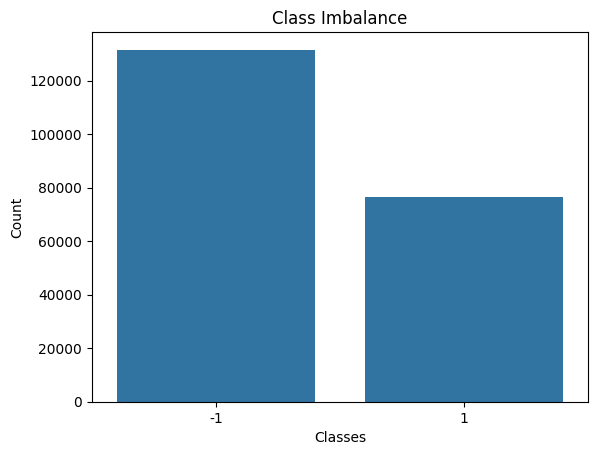

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ploting the class imbalance to analyse the target variable.
sns.countplot(x='outcome', data=df)
plt.title('Class Imbalance')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

Here the class with 1 is minority since the number of observations belonging to that class are almost half as compared to the other class. Hence to overcome this imbalance we are upsampling the minority class in a way that we do not lose any information.

In [ ]:
from sklearn.utils import resample

# Separating the minority and majority class samples.
df_majority = df[df.outcome == -1]
df_minority = df[df.outcome == 1]

# Upsampling minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # sampling with replacement
                                 n_samples=len(df_majority),  # matching majority n
                                 random_state=42)  # reproducible results
df=pd.concat([df_majority, df_minority_upsampled]) #Redefining the dataframe with the upsampled data

In [ ]:
# Checking the imbalance of the class again.
class_distribution = df['outcome'].value_counts()
print(class_distribution)

outcome
-1    131517
 1    131517
Name: count, dtype: int64


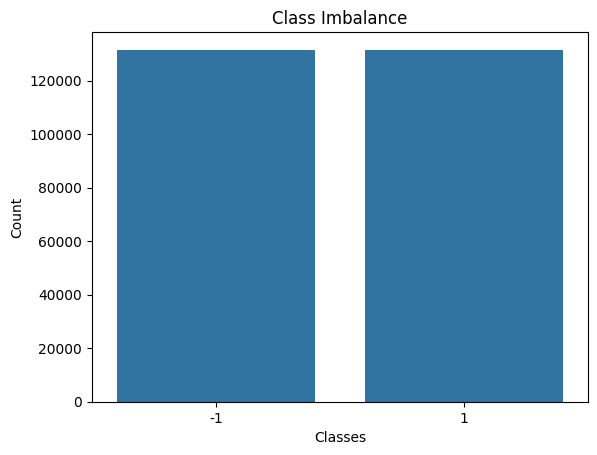

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ploting class imbalance
sns.countplot(x='outcome', data=df)
plt.title('Class Imbalance')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [ ]:
df.columns

Index(['game', 'season', 'home_team', 'away_team', 'starting_min', 'end_min',
       'home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1',
       'away_2', 'away_3', 'away_4', 'fga_home', 'fta_home', 'fgm_home',
       'fga_2_home', 'fgm_2_home', 'fga_3_home', 'fgm_3_home', 'ast_home',
       'blk_home', 'pf_home', 'reb_home', 'dreb_home', 'oreb_home', 'to_home',
       'pts_home', 'pct_home', 'pct_2_home', 'pct_3_home', 'fga_visitor',
       'fta_visitor', 'fgm_visitor', 'fga_2_visitor', 'fgm_2_visitor',
       'fga_3_visitor', 'fgm_3_visitor', 'ast_visitor', 'blk_visitor',
       'pf_visitor', 'reb_visitor', 'dreb_visitor', 'oreb_visitor',
       'to_visitor', 'pts_visitor', 'pct_visitor', 'pct_2_visitor',
       'pct_3_visitor', 'outcome'],
      dtype='object')

Hence our data is balanced now


# Data Transformation

Now encoding the player names since the machine doesnt undertand the textual data.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Here we are abstracting all the unique home players from all the home columns.
player_columns = ['home_0', 'home_1', 'home_2', 'home_3', 'home_4']

# Combining all the players
all_players = df[player_columns].values.flatten()

# Initializing and fitting the label encoder
encoder = LabelEncoder()
encoder.fit(all_players)

# Encoding player names in the dataset
for col in player_columns:
    df.loc[:, col] = encoder.transform(df[col])

In [ ]:
# Determining the number of unique home players across all the seasons.
home_vocab_size = len(encoder.classes_)
print("Home vocabulary size:", home_vocab_size)

Home vocabulary size: 955


In [ ]:
# Get the mapping of player names to numbers
home_player_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Player Name Mapping:")
print(home_player_name_mapping)

Player Name Mapping:
{'A.J. Price': 0, 'Aaron Brooks': 1, 'Aaron Gray': 2, 'Aaron McKie': 3, 'Aaron Williams': 4, 'Acie Law': 5, 'Adam Morrison': 6, 'Adonal Foyle': 7, 'Adonis Thomas': 8, 'Adrian Griffin': 9, 'Al Harrington': 10, 'Al Horford': 11, 'Al Jefferson': 12, 'Al Thornton': 13, 'Al-Farouq Aminu': 14, 'Alan Anderson': 15, 'Alan Henderson': 16, 'Alando Tucker': 17, 'Alec Burks': 18, 'Alex Acker': 19, 'Alex Len': 20, 'Alexander Johnson': 21, 'Alexey Shved': 22, 'Alexis Ajinca': 23, 'Allan Ray': 24, 'Allen Crabbe': 25, 'Allen Iverson': 26, 'Alonzo Gee': 27, 'Alonzo Mourning': 28, 'Alvin Williams': 29, "Amar'e Stoudemire": 30, 'Amir Johnson': 31, 'Anderson Varejao': 32, 'Andray Blatche': 33, 'Andre Barrett': 34, 'Andre Brown': 35, 'Andre Drummond': 36, 'Andre Emmett': 37, 'Andre Iguodala': 38, 'Andre Miller': 39, 'Andre Owens': 40, 'Andre Roberson': 41, 'Andrea Bargnani': 42, 'Andreas Glyniadakis': 43, 'Andrei Kirilenko': 44, 'Andres Nocioni': 45, 'Andrew Bogut': 46, 'Andrew Bynum':

In [ ]:
# Here we are abstracting all the unique away players from all the away columns.
player_columns = ['away_0', 'away_1', 'away_2', 'away_3', 'away_4']

# Combining all the players
all_players = df[player_columns].values.flatten()

# Initializing and fitting the label encoder
encoder = LabelEncoder()
encoder.fit(all_players)

# Encoding player names in the dataset
for col in player_columns:
    df.loc[:, col] = encoder.transform(df[col])

In [ ]:
# Determining the number of unique away players across all the seasons
away_vocab_size = len(encoder.classes_)
print(" Away vocabulary size:", away_vocab_size)

 Away vocabulary size: 949


In [ ]:
# Get the mapping of player names to numbers
away_player_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Player Name Mapping:")
print(away_player_name_mapping)

Player Name Mapping:
{'A.J. Price': 0, 'Aaron Brooks': 1, 'Aaron Gray': 2, 'Aaron McKie': 3, 'Aaron Williams': 4, 'Acie Law': 5, 'Adam Morrison': 6, 'Adonal Foyle': 7, 'Adonis Thomas': 8, 'Adrian Griffin': 9, 'Al Harrington': 10, 'Al Horford': 11, 'Al Jefferson': 12, 'Al Thornton': 13, 'Al-Farouq Aminu': 14, 'Alan Anderson': 15, 'Alan Henderson': 16, 'Alando Tucker': 17, 'Alec Burks': 18, 'Alex Acker': 19, 'Alex Len': 20, 'Alexander Johnson': 21, 'Alexey Shved': 22, 'Alexis Ajinca': 23, 'Allan Ray': 24, 'Allen Crabbe': 25, 'Allen Iverson': 26, 'Alonzo Gee': 27, 'Alonzo Mourning': 28, "Amar'e Stoudemire": 29, 'Amir Johnson': 30, 'Anderson Varejao': 31, 'Andray Blatche': 32, 'Andre Barrett': 33, 'Andre Brown': 34, 'Andre Drummond': 35, 'Andre Emmett': 36, 'Andre Iguodala': 37, 'Andre Miller': 38, 'Andre Owens': 39, 'Andre Roberson': 40, 'Andrea Bargnani': 41, 'Andreas Glyniadakis': 42, 'Andrei Kirilenko': 43, 'Andres Nocioni': 44, 'Andrew Bogut': 45, 'Andrew Bynum': 46, 'Andrew Goudelock

# Feature Engineering

In [ ]:
# Converting class labels from -1 to 0 and 1 to 1
df['outcome']=(df['outcome']+1)/2

In [ ]:
#This metric adds extra weight to three-point attempts (since they are more valuable) and divides by the total field goal attempts to measure scoring efficiency.
df['home_field_goal_efficiency']=(df['fgm_home']+(0.5*df['fga_3_home']))/df['fga_home']
#Measures how often the home team turns the ball over per field goal attempt, adjusting for free throw attempts (which contribute to possessions but not as much as regular shots).
df['home_turnover_precentage']=df['to_home']/(df['fga_home']+(0.44*df['fta_home']))
#Measures how often the home team secures an offensive rebound when there's a rebounding opportunity (total offensive rebounds / total available rebounds on offense).
df['home_offensive_rebound_percentage']=df['oreb_home']/(df['oreb_home']+df['dreb_visitor'])
#Measures how frequently the home team gets to the free-throw line relative to the number of shots made.
df['home_free_throw_rate']=df['fta_home']/df['fgm_home']

In [ ]:
df['visitor_field_goal_efficiency']=(df['fgm_visitor']+(0.5*df['fga_3_visitor']))/df['fga_visitor']
df['visitor_turnover_precentage']=df['to_visitor']/(df['fga_visitor']+(0.44*df['fta_visitor']))
df['visitor_offensive_rebound_percentage']=df['oreb_visitor']/(df['oreb_visitor']+df['dreb_home'])
df['visitor_free_throw_rate']=df['fta_visitor']/df['fgm_visitor']

In [ ]:
# Dropping the unncessary columns
df.drop(['game', 'starting_min', 'end_min',
      'fga_home', 'fta_home', 'fgm_home',
       'fga_2_home', 'fgm_2_home', 'fga_3_home', 'fgm_3_home', 'ast_home',
       'blk_home', 'pf_home', 'reb_home', 'dreb_home', 'oreb_home', 'to_home',
       'pts_home', 'pct_home', 'pct_2_home', 'pct_3_home', 'fga_visitor',
       'fta_visitor', 'fgm_visitor', 'fga_2_visitor', 'fgm_2_visitor',
       'fga_3_visitor', 'fgm_3_visitor', 'ast_visitor', 'blk_visitor',
       'pf_visitor', 'reb_visitor', 'dreb_visitor', 'oreb_visitor',
       'to_visitor', 'pts_visitor', 'pct_visitor', 'pct_2_visitor',
       'pct_3_visitor'],inplace=True,axis=1)

In [ ]:
df.columns

Index(['season', 'home_team', 'away_team', 'home_0', 'home_1', 'home_2',
       'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4',
       'outcome', 'home_field_goal_efficiency', 'home_turnover_precentage',
       'home_offensive_rebound_percentage', 'home_free_throw_rate',
       'visitor_field_goal_efficiency', 'visitor_turnover_precentage',
       'visitor_offensive_rebound_percentage', 'visitor_free_throw_rate'],
      dtype='object')

In [ ]:
df.head()

,season,home_team,away_team,home_0,home_1,home_2,home_3,home_4,away_0,away_1,...,away_4,outcome,home_field_goal_efficiency,home_turnover_precentage,home_offensive_rebound_percentage,home_free_throw_rate,visitor_field_goal_efficiency,visitor_turnover_precentage,visitor_offensive_rebound_percentage,visitor_free_throw_rate
0,2007,LAL,PHO,47,560,591,807,837,97,549,...,847,0.0,0.550000,0.085034,0.0,1.00,1.045455,0.087413,0.0,0.100000
1,2007,LAL,PHO,47,560,591,807,837,29,570,...,847,0.0,0.833333,0.666667,0.0,0.00,0.833333,0.000000,0.0,0.000000
4,2007,LAL,PHO,591,638,785,837,928,97,398,...,608,0.0,0.500000,0.000000,0.0,0.00,1.000000,1.000000,NaN,0.000000
9,2007,LAL,PHO,560,638,807,837,928,29,570,...,847,0.0,0.500000,0.000000,0.0,NaN,1.000000,0.000000,0.5,2.000000
13,2007,LAL,PHO,47,560,591,638,837,549,570,...,847,0.0,0.666667,0.155280,0.5,0.25,1.333333,0.515464,NaN,0.666667


In [ ]:
# Analysing the percentage of null values in the columns.

null_counts = df.isnull().sum()

# Calculating the total number of rows in the DataFrame
total_rows = len(df)

# Calculating the percentage of null values for each column
null_percentage = (null_counts / total_rows) * 100

print("Percentage of null values for each column:")
print(null_percentage)

Percentage of null values for each column:
season                                   0.000000
home_team                                0.000000
away_team                                0.000000
home_0                                   0.000000
home_1                                   0.000000
home_2                                   0.000000
home_3                                   0.000000
home_4                                   0.000000
away_0                                   0.000000
away_1                                   0.000000
away_2                                   0.000000
away_3                                   0.000000
away_4                                   0.000000
outcome                                  0.000000
home_field_goal_efficiency              10.576579
home_turnover_precentage                 7.800132
home_offensive_rebound_percentage       24.532570
home_free_throw_rate                    17.502300
visitor_field_goal_efficiency           12.046732
visitor

In [ ]:
# Here the percentage of null values is quite low which can be replaced by the 0.
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0,inplace=True)

<ipython-input-27-a1920cd48163>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
# Analysing the statistics of each column in the dataframe.
df.describe()

,season,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4,outcome,home_field_goal_efficiency,home_turnover_precentage,home_offensive_rebound_percentage,home_free_throw_rate,visitor_field_goal_efficiency,visitor_turnover_precentage,visitor_offensive_rebound_percentage,visitor_free_throw_rate
count,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000,263034.000000
mean,2010.468327,156.321270,312.101386,471.881384,631.699735,792.620642,155.632055,310.850863,469.430743,628.392231,788.308508,0.500000,0.572708,0.170747,0.255403,0.453927,0.477101,0.203494,0.239489,0.453534
std,2.324337,140.754688,174.051057,182.138834,169.103082,138.659899,139.161648,172.190893,180.376213,167.802855,135.697698,0.500001,0.379065,0.325753,0.338496,0.910771,0.369468,0.367628,0.321314,0.959690
min,2007.000000,0.000000,9.000000,31.000000,58.000000,75.000000,0.000000,9.000000,30.000000,57.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,46.000000,164.000000,338.000000,529.000000,724.000000,45.000000,165.000000,336.000000,527.000000,721.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
50%,2010.000000,112.000000,292.000000,470.000000,653.000000,832.000000,112.000000,291.000000,469.000000,647.000000,827.000000,0.500000,0.571429,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,2013.000000,225.000000,434.000000,611.000000,761.000000,897.000000,225.000000,432.000000,607.000000,760.000000,892.000000,1.000000,0.833333,0.230769,0.500000,0.500000,0.750000,0.265957,0.500000,0.500000
max,2014.000000,800.000000,892.000000,932.000000,946.000000,954.000000,785.000000,886.000000,921.000000,939.000000,948.000000,1.000000,1.500000,9.090909,1.000000,18.000000,1.500000,6.818182,1.000000,18.000000


In [ ]:
# Finally checking the count of null values in each column.
df.isnull().sum()

,0
season,0
home_team,0
away_team,0
home_0,0
home_1,0
home_2,0
home_3,0
home_4,0
away_0,0
away_1,0


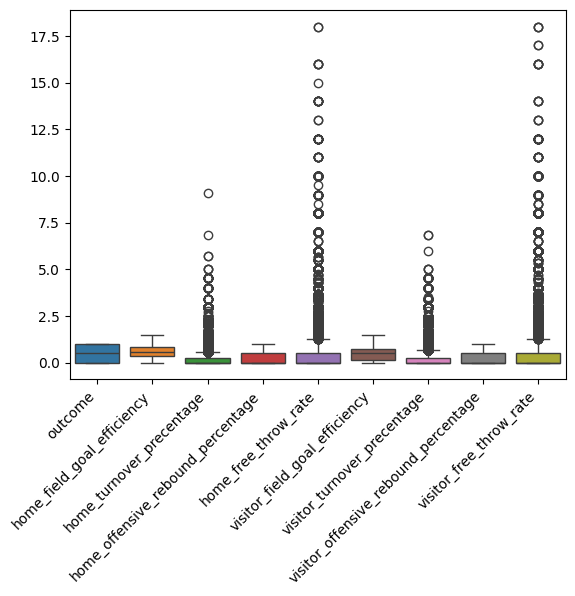

In [ ]:
# Creating a box plot to check for the outliers.

sns.boxplot(data=df[['outcome', 'home_field_goal_efficiency', 'home_turnover_precentage',
       'home_offensive_rebound_percentage', 'home_free_throw_rate',
       'visitor_field_goal_efficiency', 'visitor_turnover_precentage',
       'visitor_offensive_rebound_percentage', 'visitor_free_throw_rate']])
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Creating a new column by concatenating home players and forming an array representing the home lineup.
df['home_lineup'] = df.apply(lambda row: [row['home_0'], row['home_1'], row['home_2'], row['home_3'], row['home_4']], axis=1)
df.head()

,season,home_team,away_team,home_0,home_1,home_2,home_3,home_4,away_0,away_1,...,outcome,home_field_goal_efficiency,home_turnover_precentage,home_offensive_rebound_percentage,home_free_throw_rate,visitor_field_goal_efficiency,visitor_turnover_precentage,visitor_offensive_rebound_percentage,visitor_free_throw_rate,home_lineup
0,2007,LAL,PHO,47,560,591,807,837,97,549,...,0.0,0.550000,0.085034,0.0,1.00,1.045455,0.087413,0.0,0.100000,"[47, 560, 591, 807, 837]"
1,2007,LAL,PHO,47,560,591,807,837,29,570,...,0.0,0.833333,0.666667,0.0,0.00,0.833333,0.000000,0.0,0.000000,"[47, 560, 591, 807, 837]"
4,2007,LAL,PHO,591,638,785,837,928,97,398,...,0.0,0.500000,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.000000,"[591, 638, 785, 837, 928]"
9,2007,LAL,PHO,560,638,807,837,928,29,570,...,0.0,0.500000,0.000000,0.0,0.00,1.000000,0.000000,0.5,2.000000,"[560, 638, 807, 837, 928]"
13,2007,LAL,PHO,47,560,591,638,837,549,570,...,0.0,0.666667,0.155280,0.5,0.25,1.333333,0.515464,0.0,0.666667,"[47, 560, 591, 638, 837]"


In [ ]:
# Creating a new column by concatenating away players and forming an array representing the away lineup.
df['away_lineup'] = df.apply(lambda row: [row['away_0'], row['away_1'], row['away_2'], row['away_3'], row['away_4']], axis=1)

In [ ]:
df.head()

,season,home_team,away_team,home_0,home_1,home_2,home_3,home_4,away_0,away_1,...,home_field_goal_efficiency,home_turnover_precentage,home_offensive_rebound_percentage,home_free_throw_rate,visitor_field_goal_efficiency,visitor_turnover_precentage,visitor_offensive_rebound_percentage,visitor_free_throw_rate,home_lineup,away_lineup
0,2007,LAL,PHO,47,560,591,807,837,97,549,...,0.550000,0.085034,0.0,1.00,1.045455,0.087413,0.0,0.100000,"[47, 560, 591, 807, 837]","[97, 549, 739, 827, 847]"
1,2007,LAL,PHO,47,560,591,807,837,29,570,...,0.833333,0.666667,0.0,0.00,0.833333,0.000000,0.0,0.000000,"[47, 560, 591, 807, 837]","[29, 570, 739, 827, 847]"
4,2007,LAL,PHO,591,638,785,837,928,97,398,...,0.500000,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.000000,"[591, 638, 785, 837, 928]","[97, 398, 549, 570, 608]"
9,2007,LAL,PHO,560,638,807,837,928,29,570,...,0.500000,0.000000,0.0,0.00,1.000000,0.000000,0.5,2.000000,"[560, 638, 807, 837, 928]","[29, 570, 739, 827, 847]"
13,2007,LAL,PHO,47,560,591,638,837,549,570,...,0.666667,0.155280,0.5,0.25,1.333333,0.515464,0.0,0.666667,"[47, 560, 591, 638, 837]","[549, 570, 739, 827, 847]"


In [ ]:
df.columns

Index(['season', 'home_team', 'away_team', 'home_0', 'home_1', 'home_2',
       'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4',
       'outcome', 'home_field_goal_efficiency', 'home_turnover_precentage',
       'home_offensive_rebound_percentage', 'home_free_throw_rate',
       'visitor_field_goal_efficiency', 'visitor_turnover_precentage',
       'visitor_offensive_rebound_percentage', 'visitor_free_throw_rate',
       'home_lineup', 'away_lineup'],
      dtype='object')

# Model for generating embeddings

Tranforming the data to make it ready for the model to generate embeddings

In [ ]:
# Stacking the arrays along axis=1 to make them understandable by neural network.
array = np.stack(df['home_lineup'])
home_array = [', '.join(map(str, row)) for row in array]

# Defining the home lineups in X_home which will then be used to generate embeddings for each home player.
X_home= [[int(x) for x in row.split(', ')] for row in home_array]
X_home = np.array(X_home)

array = np.stack(df['away_lineup'])
away_array = [', '.join(map(str, row)) for row in array]

# Defining the away lineups in X_away which will then be used to generate embeddings for each away player.
X_away= [[int(x) for x in row.split(', ')] for row in away_array]
X_away = np.array(X_away)

# Defining the target variable which is the outcome of the game.
y=df['outcome']

In [ ]:
# Defining the statistics for home and away lineups in X_stats.
X_stats=df[[ 'home_field_goal_efficiency', 'home_turnover_precentage',
       'home_offensive_rebound_percentage', 'home_free_throw_rate','visitor_field_goal_efficiency', 'visitor_turnover_precentage',
       'visitor_offensive_rebound_percentage', 'visitor_free_throw_rate']]

In [ ]:
# Importing the necesary libraries for model building.
from keras.models import Model
from keras.layers import Input, Concatenate, Embedding, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

num_stats=8 # We have four stats for home and four stats for away teams.

home_player_comb_input = Input(shape=(5,)) # Since the combinations are of 5 players.
away_player_comb_input = Input(shape=(5,))
stats_input = Input(shape=(num_stats,))  # Assuming num_stats is the number of stats per combination.

# Adding the embedding layer for home player combinations
home_player_embedding_layer = Embedding(input_dim=home_vocab_size, output_dim=32, name='home_embedding')(home_player_comb_input)
flattened_home_player_embedding = Flatten()(home_player_embedding_layer)

# Adding embedding layer for away player combinations.
away_player_embedding_layer = Embedding(input_dim=away_vocab_size, output_dim=32, name='away_embedding')(away_player_comb_input)
flattened_away_player_embedding = Flatten()(away_player_embedding_layer)

# Concatenating the flattened player embeddings with stats input.
concatenated_features = Concatenate()([flattened_home_player_embedding, flattened_away_player_embedding, stats_input])

# Adding dense layers for further processing.
hidden_layer = Dense(32, activation='relu')(concatenated_features)

output_layer = Dense(1, activation='sigmoid')(hidden_layer)

# Defining the model
model = Model(inputs=[home_player_comb_input, away_player_comb_input, stats_input], outputs=output_layer)

# Defining the initial learning rate.
initial_learning_rate = 0.001
opt = Adam(learning_rate=initial_learning_rate)

# Defining loss function as binary_crossentropy sice the target variable is binary.
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define learning rate scheduler to automatically change the learning rate by monitoring the validation loss.
change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Defining early stopping criteria in order to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Printing model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ home_embedding            │ (None, 5, 32)          │         30,560 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ away_embedding            │ (None, 5, 32)          │         30,368 │ input_layer_1[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 160)            │              0 │ home_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 160)            │              0 │ away_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 328)            │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         10,528 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             33 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 71,489 (279.25 KB)

 Trainable params: 71,489 (279.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Training the model with learning rate schedule.
home_history = model.fit([X_home, X_away, X_stats], y, epochs=50, batch_size=32, validation_split=0.2,callbacks=[change_lr, early_stop])

Epoch 1/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8515 - loss: 0.3325 - val_accuracy: 0.8378 - val_loss: 0.3572 - learning_rate: 0.0010
Epoch 2/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8986 - loss: 0.2335 - val_accuracy: 0.8720 - val_loss: 0.2985 - learning_rate: 0.0010
Epoch 3/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9105 - loss: 0.2095 - val_accuracy: 0.8738 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 4/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9188 - loss: 0.1931 - val_accuracy: 0.8872 - val_loss: 0.2759 - learning_rate: 0.0010
Epoch 5/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9262 - loss: 0.1763 - val_accuracy: 0.8784 - val_loss: 0.3015 - learning_rate: 0.0010
Epoch 6/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9346 - loss: 0.1612 - val_accuracy: 0.8529 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 7/50
6576/6576 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.93

In [ ]:
# Storing the weights which are the 32-dimensional feature vectors for the home players in the dictionary.
home_weights=model.get_layer('home_embedding').get_weights()[0]
home_player_weights = {index: array for index, array in enumerate(home_weights)}
print(home_player_weights)

{0: array([ 0.05544077,  0.09095291, -0.00075485,  0.13209428,  0.1911141 ,
       -0.16868976,  0.10475338,  0.00951735, -0.00025295,  0.15101688,
        0.16924302, -0.07521584,  0.15916356, -0.06980324, -0.01654171,
       -0.04562142,  0.16192672,  0.09056   , -0.02847453, -0.00069139,
        0.13578963,  0.09057256, -0.05944279,  0.0146702 ,  0.03733494,
       -0.03633374, -0.03677655,  0.07821236,  0.09835976,  0.00927628,
       -0.04224689,  0.1969677 ], dtype=float32), 1: array([ 0.00283096,  0.11298076,  0.01127929,  0.10049149,  0.02188627,
       -0.09872726, -0.10701922,  0.0842416 , -0.04260964, -0.08687412,
        0.03477648, -0.03353402,  0.04383517,  0.13478795,  0.02156308,
        0.13796234, -0.15381269,  0.03706973, -0.06491927,  0.01662749,
       -0.13916512, -0.10662445,  0.0332967 ,  0.05621181,  0.12013029,
        0.19337332, -0.02407179,  0.0421831 , -0.2213556 ,  0.10575389,
        0.08603057,  0.16751224], dtype=float32), 2: array([ 0.21584165, -0.025

In [ ]:
# Storing the weights which are the 32-dimensional feature vectors for the away players in the dictionary.
away_weights=model.get_layer('away_embedding').get_weights()[0]
# Using dictionary comprehension
away_player_weights = {index: array for index, array in enumerate(away_weights)}

print(away_player_weights)

{0: array([-1.73644155e-01,  2.69612167e-02, -1.01514839e-01,  1.16097726e-01,
        1.74312055e-01, -1.59158319e-01, -6.34164587e-02, -1.47849843e-01,
        2.33509927e-03,  4.43162732e-02,  9.88266468e-02,  1.15383312e-01,
        1.41187653e-01,  1.16793849e-01, -8.47300366e-02, -8.96976218e-02,
       -4.29479331e-02, -3.12663056e-02, -1.40643999e-01, -3.09663615e-03,
        6.55157715e-02, -1.22663900e-02, -8.91998485e-02, -6.91104308e-03,
        4.83969264e-02,  1.44453645e-01,  1.06963061e-03,  9.65219736e-02,
        6.44952990e-03, -7.82481059e-02, -4.40076619e-05,  1.33278012e-01],
      dtype=float32), 1: array([-1.89457263e-03, -5.89636620e-05,  7.82427043e-02,  1.40515804e-01,
       -5.80154136e-02,  4.63543423e-02, -1.15284115e-01, -9.84063372e-02,
        1.48626924e-01, -5.46610951e-02,  1.04595788e-01, -1.29901394e-01,
       -1.47864655e-01,  3.99000384e-02, -1.22751534e-01,  2.14799210e-01,
        1.44373357e-01, -6.22502826e-02,  2.99011134e-02,  2.42659729e

In [ ]:
# Mapping these 32 dimensional vectors in the datframe.
for col in ['home_0', 'home_1', 'home_2', 'home_3', 'home_4']:
    df[col] = df[col].map(home_player_weights)

In [ ]:
for col in ['away_0', 'away_1', 'away_2', 'away_3', 'away_4']:
    df[col] = df[col].map(away_player_weights)

In [ ]:
# Preparing the X and y variables for our final classification model to classify embeddings as win or loss.
X = df[['home_0', 'home_1', 'home_2', 'home_3', 'home_4','away_0', 'away_1', 'away_2', 'away_3', 'away_4']].values
y = df['outcome'].values
X_flat = np.vstack([np.concatenate(arr) for arr in X])

# Model Building for classifying the embeddings.

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Splitting data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Defining the logistic regression model.
lr_model = LogisticRegression(max_iter=10000)

# Performing 5-fold cross_validation.
accuracies = cross_val_score(lr_model, X_train, y_train, cv=5)
lr_model.fit(X_train, y_train)

# Evaluating model performance.
print("Train Score:",np.mean(accuracies))
print("Test Score:",lr_model.score(X_test,y_test))

Train Score: 0.5697367779393384
Test Score: 0.572319273100538


In [ ]:
# Making predictions
y_pred=lr_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
# Calculating and printing classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54     26167
         1.0       0.56      0.65      0.60     26440

    accuracy                           0.57     52607
   macro avg       0.57      0.57      0.57     52607
weighted avg       0.57      0.57      0.57     52607



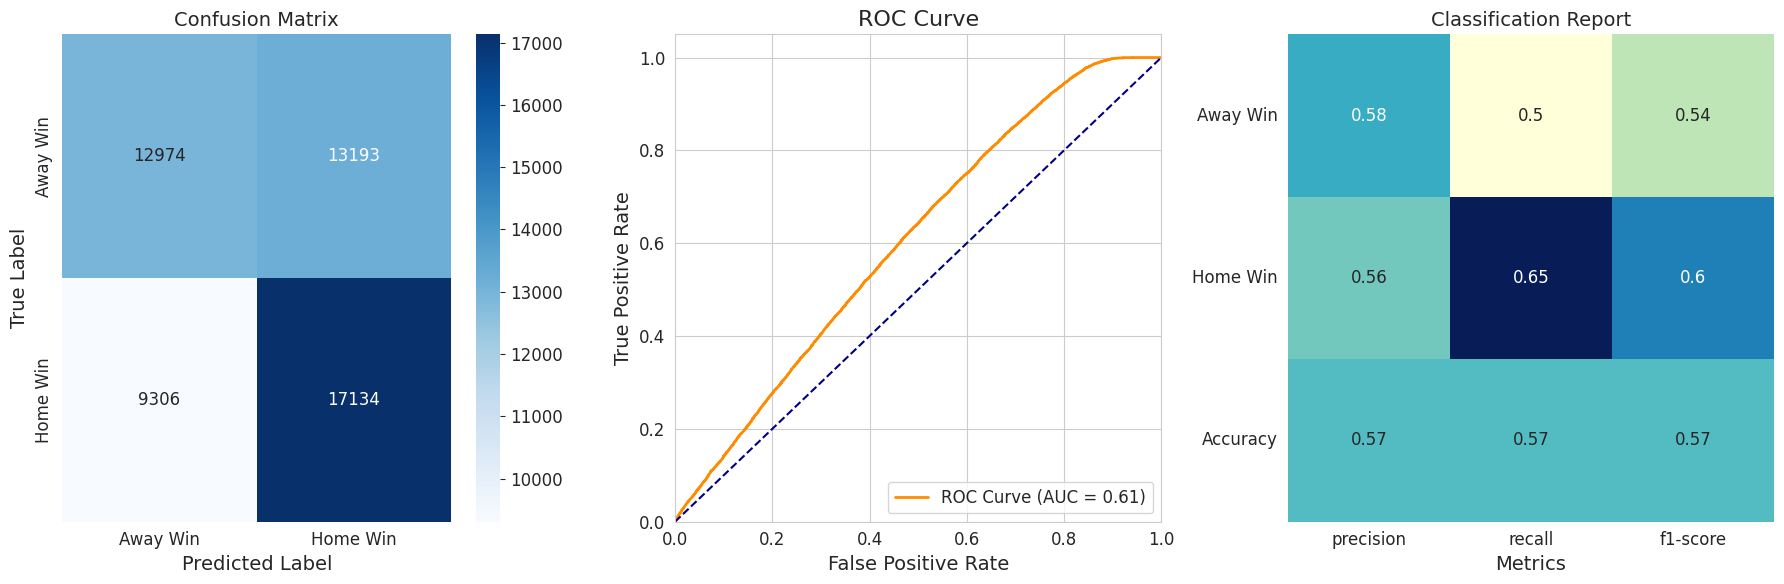

Mean CV Accuracy: 0.570 (±0.002)
Test Set Accuracy: 0.572


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_model_diagnostics(model, X_test, y_test):
    """Create three-panel diagnostic plot for classification models"""
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig

# Data splitting and model training
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression(max_iter=10000)
accuracies = cross_val_score(lr_model, X_train, y_train, cv=5)
lr_model.fit(X_train, y_train)

# Generate and display diagnostics
fig = plot_model_diagnostics(lr_model, X_test, y_test)
plt.show()

# Print performance metrics
print(f"Mean CV Accuracy: {np.mean(accuracies):.3f} (±{np.std(accuracies):.3f})")
print(f"Test Set Accuracy: {lr_model.score(X_test, y_test):.3f}")

# Optional: Save the figure
# plt.savefig('logreg_diagnostics.png', dpi=300, bbox_inches='tight')

# SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Scale the features - crucial for SVM performance
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure balanced split
)

# Create optimized LinearSVC model
svm_model = LinearSVC(
    dual='auto',          # Let sklearn choose the best solver
    C=1.0,               # Regularization parameter
    max_iter=2000,       # Increase max iterations for convergence
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    tol=1e-4            # Tolerance for stopping criterion
)

# Train the model
print("Training model...")
svm_model.fit(X_train, y_train)

# Make predictions
print("Making predictions...")
y_pred = svm_model.predict(X_test)

# Print results
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature importances (absolute values of coefficients)
feature_importance = np.abs(svm_model.coef_[0])
top_features = np.argsort(feature_importance)[-5:]  # Get top 5 features
print("\nTop 5 most important features:")
for idx in reversed(top_features):
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")

Training model...
Making predictions...

Accuracy: 0.5677191248312962

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.48      0.52     26304
         1.0       0.56      0.66      0.60     26303

    accuracy                           0.57     52607
   macro avg       0.57      0.57      0.56     52607
weighted avg       0.57      0.57      0.56     52607


Top 5 most important features:
Feature 3: 0.0499
Feature 86: 0.0426
Feature 122: 0.0424
Feature 127: 0.0400
Feature 54: 0.0377


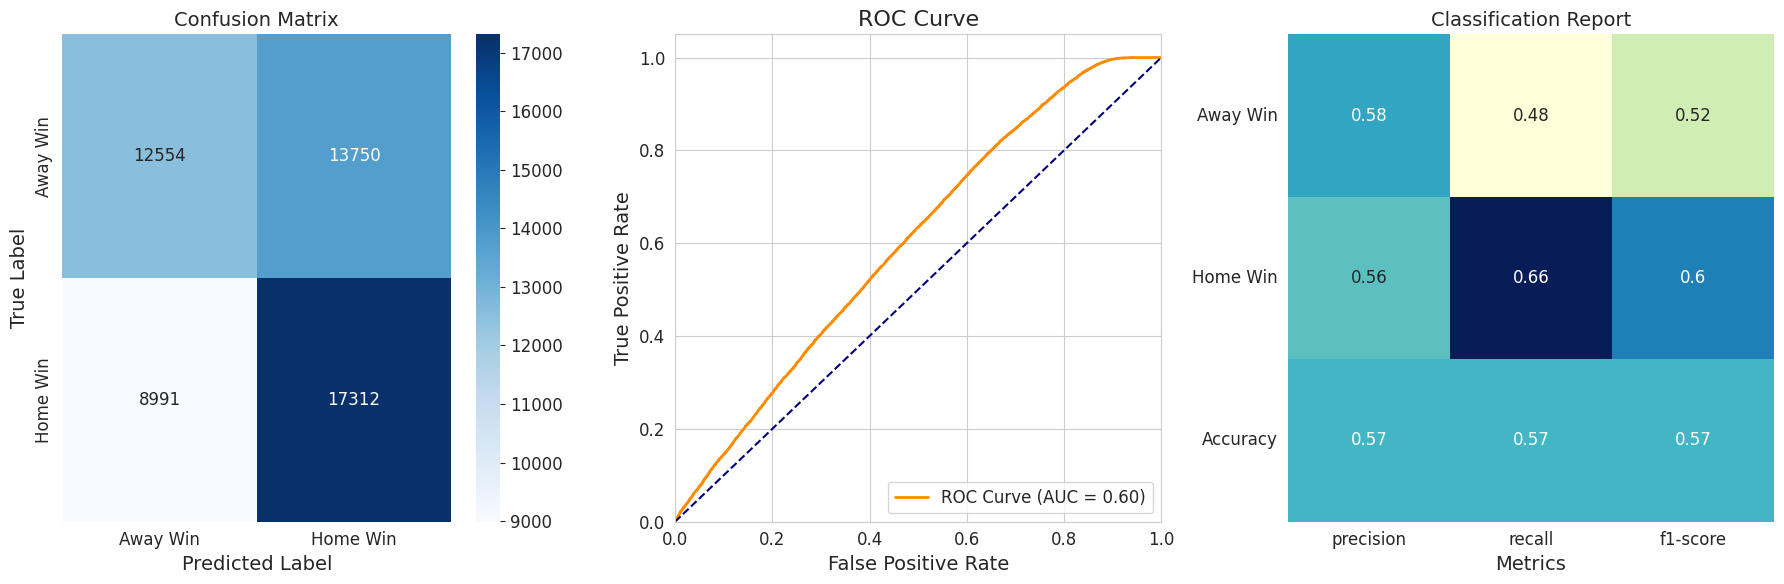

Test Accuracy: 0.568

Top 5 Features:
Feature 3: 0.0499
Feature 86: 0.0426
Feature 122: 0.0424
Feature 127: 0.0400
Feature 54: 0.0377


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_svm_diagnostics(model, X_test, y_test):
    """Create diagnostic plots for SVM model"""
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and decision scores
    y_pred = model.predict(X_test)
    decision_scores = model.decision_function(X_test)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, decision_scores)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig

# Generate and display diagnostics
fig = plot_svm_diagnostics(svm_model, X_test, y_test)
plt.show()

# Print performance summary
print(f"Test Accuracy: {svm_model.score(X_test, y_test):.3f}")
print("\nTop 5 Features:")
feature_importance = np.abs(svm_model.coef_[0])
for idx in np.argsort(feature_importance)[-5:][::-1]:
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")

# Neural Networks

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3287/3288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5457 - loss: 0.7074
Epoch 1: val_accuracy improved from -inf to 0.57954, saving model to best_model.keras
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.5458 - loss: 0.7073 - val_accuracy: 0.5795 - val_loss: 0.6502 - learning_rate: 5.0000e-04
Epoch 2/100
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5824 - loss: 0.6520
Epoch 2: val_accuracy improved from 0.57954 to 0.58260, saving model to best_model.keras
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.5824 - loss: 0.6520 - val_accuracy: 0.5826 - val_loss: 0.6434 - learning_rate: 5.0000e-04
Epoch 3/100
3286/3288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5912 - loss: 0.6439
Epoch 3: val_accuracy improved from 0.58260 to 0.58888, saving model to best_model.keras
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.5912 - loss: 0.6439 - val_accuracy: 0.5889 - val_loss: 0.6399 - learning_rate: 5.0000e-04
Epoch 4/100
3288/32

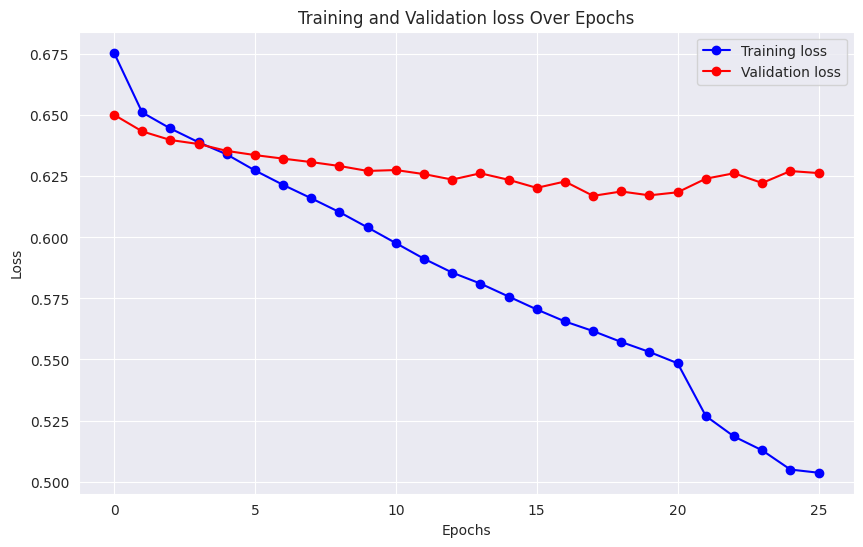

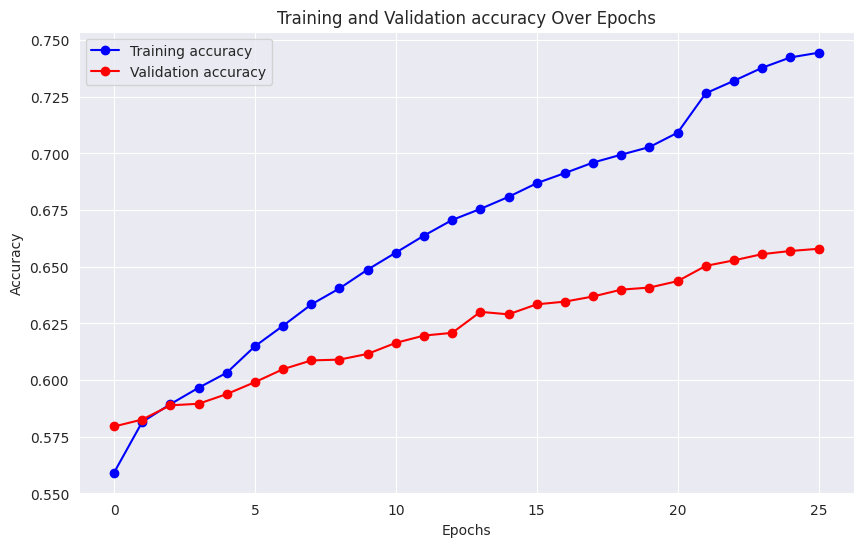

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

# Scale the features
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Define a more sophisticated model architecture
model = Sequential([
    # Input layer with batch normalization
    Dense(512, input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Hidden layers with decreasing neurons
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile with a lower initial learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Train the model with a larger batch size
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions and calculate metrics
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate detailed metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


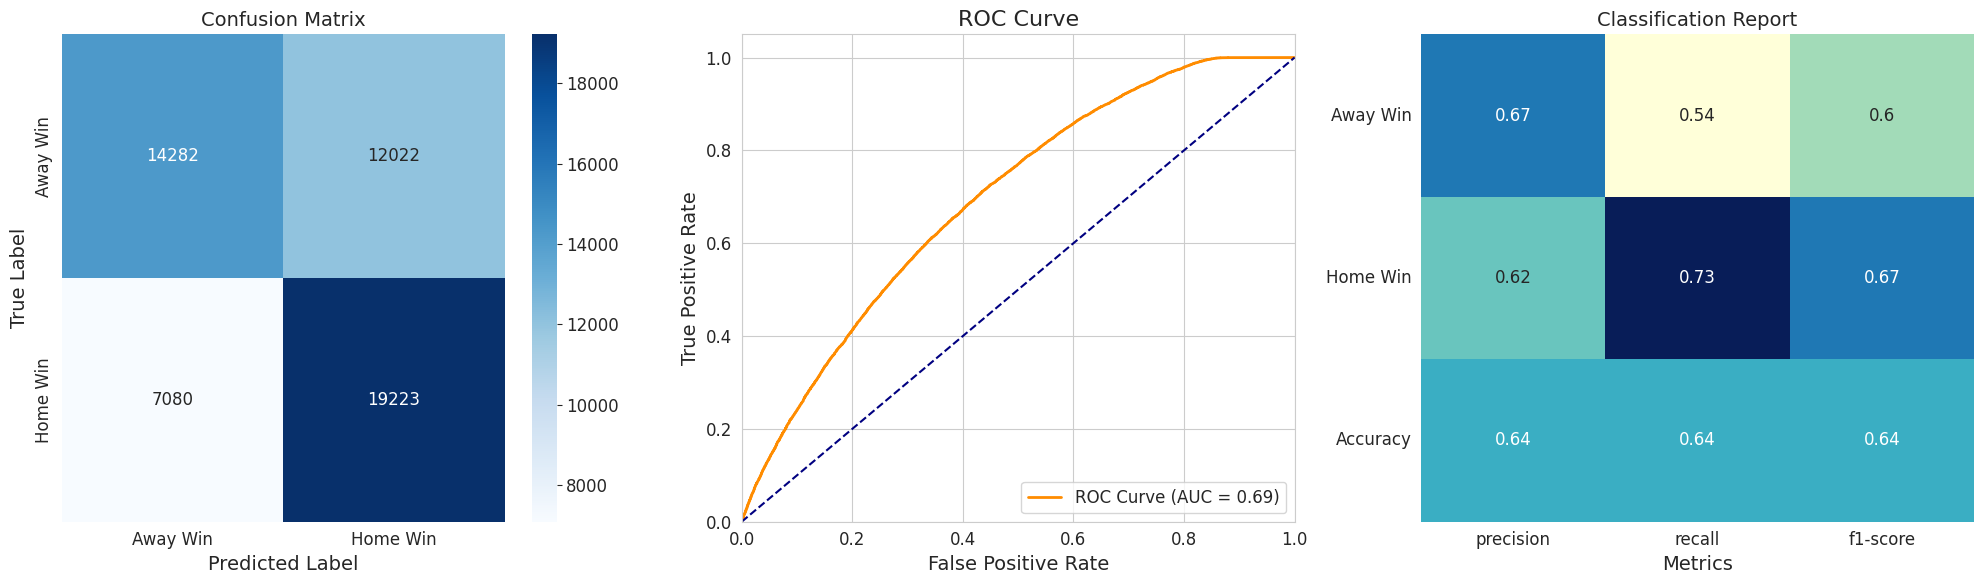

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_nn_diagnostics(model, X_test, y_test):
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig

# Generate and display plots after model evaluation
fig = plot_nn_diagnostics(model, X_test, y_test)
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale features - this is important but not computationally heavy
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Stratified split to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X_flat_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create a more efficient but improved model
rf_model = RandomForestClassifier(
    n_estimators=100,        # Moderate number of trees
    max_depth=15,           # Reasonable depth
    min_samples_split=10,   # Balanced value
    min_samples_leaf=4,     # Balanced value
    max_features='sqrt',    # Reduces feature consideration at each split
    n_jobs=2,              # Use only 2 CPU cores to prevent freezing
    class_weight='balanced', # Handle class imbalance
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get top 5 feature importances (limited to save memory)
feature_importance = rf_model.feature_importances_
top_features = np.argsort(feature_importance)[-5:]
print("\nTop 5 most important features:")
for idx in reversed(top_features):
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")

Accuracy: 0.6059459767711521

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.25      0.39     26304
         1.0       0.56      0.96      0.71     26303

    accuracy                           0.61     52607
   macro avg       0.71      0.61      0.55     52607
weighted avg       0.71      0.61      0.55     52607


Top 5 most important features:
Feature 26: 0.0320
Feature 90: 0.0234
Feature 15: 0.0228
Feature 40: 0.0190
Feature 4: 0.0187


In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Calculating and printing classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.25      0.39     26304
         1.0       0.56      0.96      0.71     26303

    accuracy                           0.61     52607
   macro avg       0.71      0.61      0.55     52607
weighted avg       0.71      0.61      0.55     52607



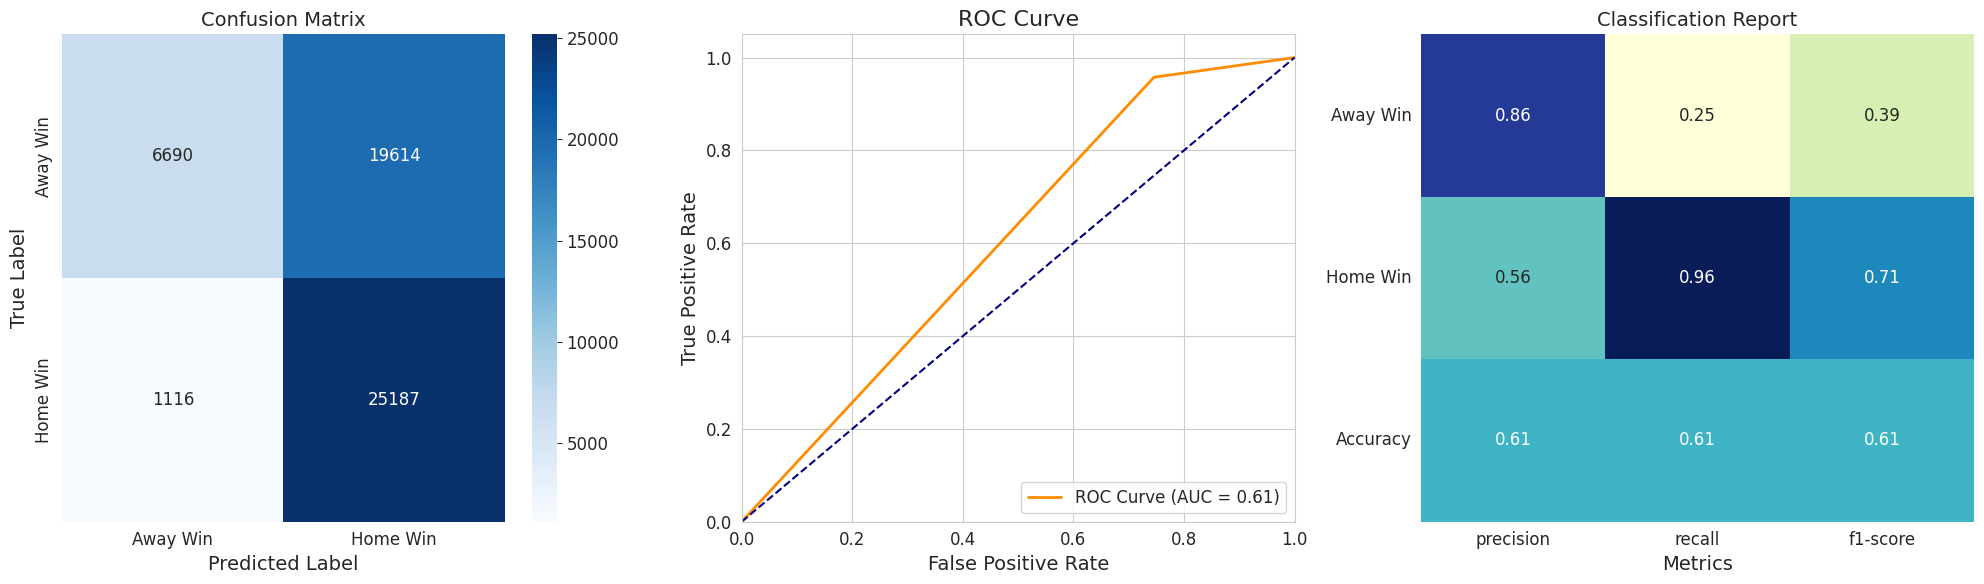

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_rf_diagnostics(model, X_test, y_test):
    """Create diagnostic plots for Random Forest model"""
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig

# Generate and display plots after model evaluation
fig = plot_rf_diagnostics(rf_model, X_test, y_test)
plt.show()

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.decomposition import PCA

# Scale the features - crucial for distance-based algorithms
print("Scaling features...")
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Apply PCA to reduce dimensionality while preserving 95% of variance
print("Applying PCA...")
pca = PCA(n_components=0.95, random_state=42)
X_flat_reduced = pca.fit_transform(X_flat_scaled)
print(f"Reduced dimensions from {X_flat_scaled.shape[1]} to {X_flat_reduced.shape[1]} features")

# Split the reduced data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat_reduced,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create optimized KNN classifier
knn_classifier = KNeighborsClassifier(
    n_neighbors=5,           # Odd number to avoid ties
    weights='distance',      # Weight points by distance
    metric='cosine',        # Cosine similarity often works well for high-dim data
    n_jobs=2,               # Parallel processing but not too intensive
    leaf_size=30            # Optimal for cosine distance
)

# Perform quick cross-validation
print("\nPerforming cross-validation...")
cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=3, n_jobs=2)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train the final model
print("\nTraining final model...")
knn_classifier.fit(X_train, y_train)

# Make predictions
print("Making predictions...")
y_pred = knn_classifier.predict(X_test)

# Calculate and print metrics
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate predictions probabilities
y_pred_proba = knn_classifier.predict_proba(X_test)

# Print confidence metrics
print("\nPrediction Confidence Analysis:")
confidence_scores = np.max(y_pred_proba, axis=1)
print(f"Mean confidence: {confidence_scores.mean():.3f}")
print(f"Min confidence: {confidence_scores.min():.3f}")
print(f"Max confidence: {confidence_scores.max():.3f}")

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 253 features

Performing cross-validation...
Cross-validation scores: [0.67620433 0.67575775 0.67753985]
Mean CV accuracy: 0.677 (+/- 0.002)

Training final model...
Making predictions...

Model Evaluation:
Accuracy: 0.7149238694470318

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.58      0.67     26304
         1.0       0.67      0.85      0.75     26303

    accuracy                           0.71     52607
   macro avg       0.73      0.71      0.71     52607
weighted avg       0.73      0.71      0.71     52607


Prediction Confidence Analysis:
Mean confidence: 0.860
Min confidence: 0.500
Max confidence: 1.000


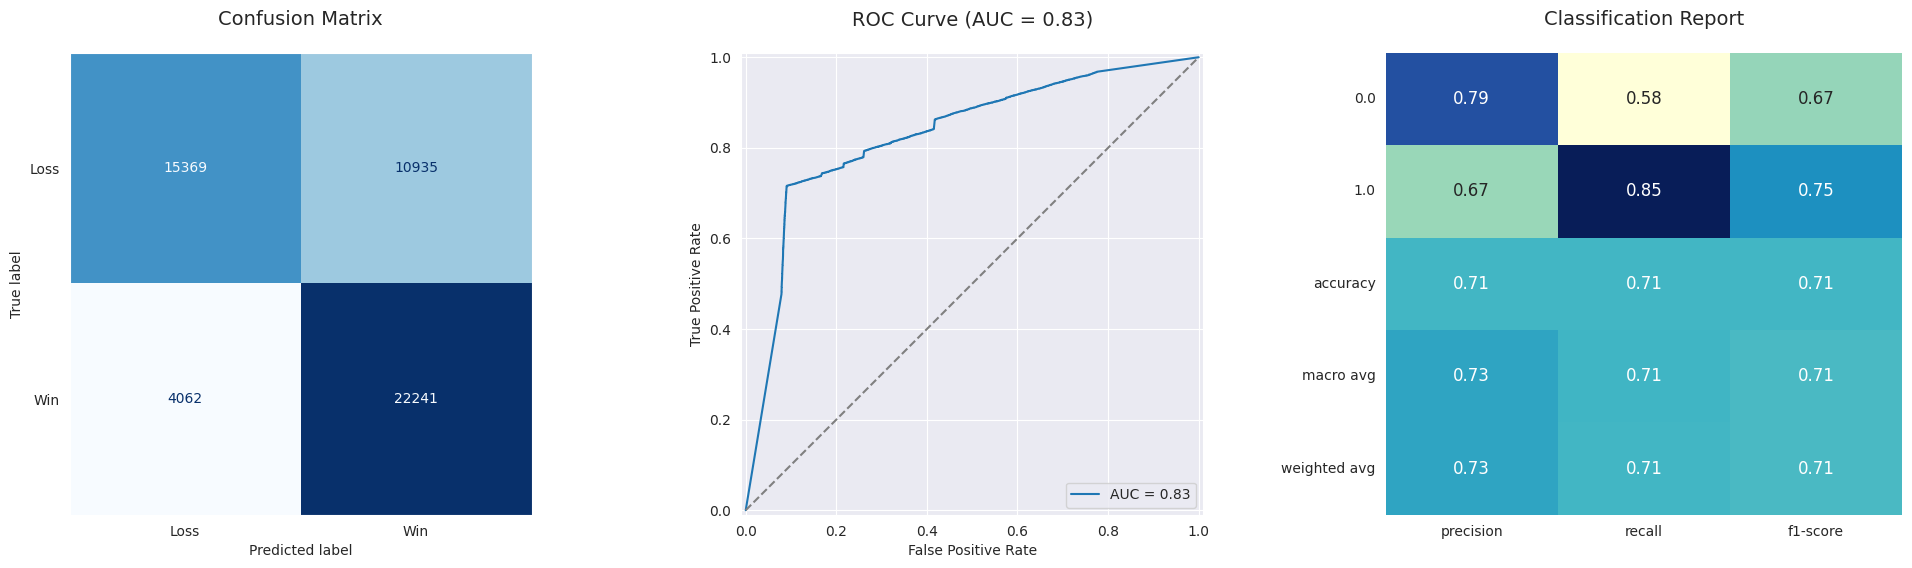

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.metrics import roc_curve, auc

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Win'])
disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix', fontsize=14, pad=20)
ax[0].grid(False)

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot(ax=ax[1], color='#1f77b4')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc), fontsize=14, pad=20)

# 3. Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'support'

# Get the original index labels (class names, 'accuracy', etc.)
original_labels = report_df.index.tolist()

sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f',
           cbar=False, ax=ax[2], annot_kws={'size': 12})
ax[2].set_title('Classification Report', fontsize=14, pad=20)

# Set y-tick labels using the original labels
ax[2].set_yticklabels(original_labels, rotation=0)

# Save and display
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Defining test case

Since the KNN gave us the best results till now we will consider it to perform lineup suggestion.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

def load_and_validate_data(file_path):
    """Load data and perform basic validation."""
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

def get_team_players(df, away_team, home_team, season):
    """Extract players for given teams and season with validation."""
    away_team_data = df[(df['away_team'] == away_team) & (df['season'] == season)]
    home_team_data = df[(df['home_team'] == home_team) & (df['season'] == season)]

    if away_team_data.empty or home_team_data.empty:
        raise ValueError(f"No data found for {away_team} vs {home_team} in season {season}")

    away_players = away_team_data[['away_1', 'away_2', 'away_3', 'away_0', 'away_4']].values.flatten()
    home_players = home_team_data[['home_1', 'home_2', 'home_3', 'home_0', 'home_4']].values.flatten()

    return pd.unique(away_players), pd.unique(home_players)

def prepare_player_embeddings(players, player_mapping, player_weights):
    """Prepare player embeddings with error checking."""
    embeddings = []
    for player in players:
        player_code = player_mapping.get(player)
        if player_code is None:
            raise ValueError(f"Player not found in mapping: {player}")

        embedding = player_weights.get(player_code)
        if embedding is None:
            raise ValueError(f"No embedding found for player: {player}")

        embeddings.append(embedding)
    return embeddings

def find_candidate_players(all_players, selected_players, player_mapping, player_weights):
    """Find and validate candidate players for lineup."""
    remaining_players = list(set(all_players) - set(selected_players))
    candidate_embeddings = []
    candidate_codes = []

    for player in remaining_players:
        code = player_mapping.get(player)
        if code is not None:
            embedding = player_weights.get(code)
            if embedding is not None:
                candidate_embeddings.append(embedding)
                candidate_codes.append(code)

    return candidate_embeddings, candidate_codes

def prepare_prediction_data(home_embeddings, away_embeddings, candidate_embeddings):
    """Prepare data for model prediction with shape validation."""
    X_input = []
    for candidate in candidate_embeddings:
        combined = home_embeddings + away_embeddings + [candidate]
        X_input.append(np.concatenate(combined))

    X_input_flat = np.vstack(X_input)
    expected_shape = len(home_embeddings[0]) * len(home_embeddings) + \
                    len(away_embeddings[0]) * len(away_embeddings) + \
                    len(candidate_embeddings[0])

    if X_input_flat.shape[1] != expected_shape:
        raise ValueError(f"Incorrect feature dimension. Expected {expected_shape}, got {X_input_flat.shape[1]}")

    return X_input_flat

def predict_lineup(X_input_flat, scaler, pca, knn_classifier):
    """Make predictions using the trained model components."""
    try:
        X_scaled = scaler.transform(X_input_flat)
        X_reduced = pca.transform(X_scaled)
        predictions = knn_classifier.predict(X_reduced)
        probabilities = knn_classifier.predict_proba(X_reduced)
        return predictions, probabilities
    except Exception as e:
        raise Exception(f"Error during prediction: {str(e)}")

def main_prediction_pipeline(
    data_path,
    away_team,
    home_team,
    season,
    away_players_selected,
    home_players_selected,
    away_player_mapping,
    home_player_mapping,
    away_player_weights,
    home_player_weights,
    scaler,
    pca,
    knn_classifier
):
    """Main prediction pipeline with full error handling."""
    try:
        # Load and validate data
        df = load_and_validate_data(data_path)

        # Get team players
        all_away_players, all_home_players = get_team_players(df, away_team, home_team, season)

        # Prepare embeddings for selected players
        away_embeddings = prepare_player_embeddings(
            away_players_selected, away_player_mapping, away_player_weights)
        home_embeddings = prepare_player_embeddings(
            home_players_selected, home_player_mapping, home_player_weights)

        # Find candidate players
        candidate_embeddings, candidate_codes = find_candidate_players(
            all_away_players, away_players_selected, away_player_mapping, away_player_weights)

        # Prepare prediction data
        X_input_flat = prepare_prediction_data(
            home_embeddings, away_embeddings, candidate_embeddings)

        # Make predictions
        predictions, probabilities = predict_lineup(
            X_input_flat, scaler, pca, knn_classifier)

        # Process results
        results = []
        for i, code in enumerate(candidate_codes):
            if predictions[i] == 0:  # Away team wins
                player_name = next(
                    (name for name, value in away_player_mapping.items() if value == code), None)
                if player_name:
                    results.append({
                        'player_name': player_name,
                        'win_probability': probabilities[i][0]
                    })

        # Sort results
        results.sort(key=lambda x: x['win_probability'], reverse=True)
        return results

    except Exception as e:
        raise Exception(f"Error in prediction pipeline: {str(e)}")

def display_results(results):
    """Display formatted prediction results."""
    print("\nPotential 5th players for away team win (sorted by probability):")
    print("-" * 60)
    print(f"{'Player Name':<30} {'Win Probability':<15}")
    print("-" * 60)

    for result in results:
        print(f"{result['player_name']:<30} {result['win_probability']:.4f}")

    print("-" * 60)

In [ ]:
try:
    results = main_prediction_pipeline(
        data_path="/content/matchups-2015.csv",
        away_team="GSW",
        home_team="SAC",
        season=2015,
        away_players_selected=['Draymond Green', 'Harrison Barnes', 'Klay Thompson',
       'Andrew Bogut'],
        home_players_selected=['Darren Collison', 'DeMarcus Cousins', 'Jason Thompson',
       'Ben McLemore', 'Rudy Gay'],
        away_player_mapping=away_player_name_mapping,
        home_player_mapping=home_player_name_mapping,
        away_player_weights=away_player_weights,
        home_player_weights=home_player_weights,
        scaler=scaler,
        pca=pca,
        knn_classifier=knn_classifier
    )

    display_results(results)

except Exception as e:
    print(f"Error: {str(e)}")


Potential 5th players for away team win (sorted by probability):
------------------------------------------------------------
Player Name                    Win Probability
------------------------------------------------------------
Stephen Curry                  0.6107
Ognjen Kuzmic                  0.6096
Leandro Barbosa                0.6094
Brandon Rush                   0.6082
David Lee                      0.6076
Shaun Livingston               0.6040
Justin Holiday                 0.6032
Festus Ezeli                   0.6021
Marreese Speights              0.6016
Andre Iguodala                 0.6012
------------------------------------------------------------


In [ ]:
# Reading the data ansd storing it in a variable to lookup for the players based on the input teams.
data_2015 =pd.read_csv("/content/matchups-2015.csv")
df1=pd.concat([data_2015])

Defining home team, away team and season

In [ ]:
away_name_input = input("Enter the AWAY team: ")
home_name_input = input("Enter the HOME team: ")
team_year_input = input("Enter the season: ")
team_year_input=int(team_year_input)

Enter the AWAY team: GSW
Enter the HOME team: SAC
Enter the season: 2015


In [ ]:
# Getting the home and away players based of the input teams from the input year.
away_team_data = df1[(df1['away_team'] == away_name_input) & (df1['season'] == team_year_input)]
home_team_data = df1[(df1['home_team'] == home_name_input) & (df1['season'] == team_year_input)]

away_players = away_team_data[['away_1', 'away_2', 'away_3', 'away_0', 'away_4']].values.flatten()
home_players = home_team_data[['home_1', 'home_2', 'home_3', 'home_0', 'home_4']].values.flatten()

# Getting all the unique players for home and away teams.
unique_away_players = pd.unique(away_players)
unique_home_players = pd.unique(home_players)

In [ ]:
unique_home_players

array(['Darren Collison', 'DeMarcus Cousins', 'Jason Thompson',
       'Ben McLemore', 'Rudy Gay', 'Nik Stauskas', 'Carl Landry',
       'Derrick Williams', 'Ramon Sessions', 'Reggie Evans',
       'Omri Casspi', 'Quincy Miller', 'Ray McCallum', 'Ryan Hollins',
       'Andre Miller'], dtype=object)

In [ ]:
unique_away_players

array(['Draymond Green', 'Harrison Barnes', 'Klay Thompson',
       'Andrew Bogut', 'Stephen Curry', 'Festus Ezeli',
       'Marreese Speights', 'Andre Iguodala', 'Leandro Barbosa',
       'Justin Holiday', 'Ognjen Kuzmic', 'Shaun Livingston',
       'Brandon Rush', 'David Lee', 'James Michael McAdoo'], dtype=object)

Defining 5 members for home team and 4 members for away team.

In [ ]:
home_team_trial_names=['Darren Collison', 'DeMarcus Cousins', 'Jason Thompson',
       'Ben McLemore', 'Rudy Gay']
away_team_trial_names=['Draymond Green', 'Harrison Barnes', 'Klay Thompson',
       'Andrew Bogut']

In [ ]:
# Getting the encoded values for the input players form the respective home and away dictionaries defined earlier.
away_team_trial_enco=[]
home_team_trial_enco=[]

for player in away_team_trial_names:
    away_team_trial_enco.append(away_player_name_mapping.get(player))
    print("Away player name:", player, "Mapped value:", away_player_name_mapping.get(player))

for player in home_team_trial_names:
    home_team_trial_enco.append(home_player_name_mapping.get(player))
    print("Home player name:", player, "Mapped value:", home_player_name_mapping.get(player))

In [ ]:
# Fetching the embeddings from the encoded values from the home and away dictionaries defined earlier.
away_team_embeddings=[]
home_team_embeddings=[]
for player in away_team_trial_enco:
    away_team_embeddings.append(away_player_weights.get(player))
    print("Away player value:", player, "Embedding:", away_player_weights.get(player))

for player in home_team_trial_enco:
    home_team_embeddings.append(home_player_weights.get(player))
    print("Home player value:", player, "Embedding:", home_player_weights.get(player))

In [ ]:
print("Length of one home player embedding:", len(home_team_embeddings[0]))
print("Length of one away player embedding:", len(away_team_embeddings[0]))
print("Number of home players:", len(home_team_embeddings))
print("Number of away players:", len(away_team_embeddings))

In [ ]:
# Getting the remaining players for the away team which can become a part of lineup and getting their encoded values.

# Converting lists to sets
set1 = set(unique_away_players)
set2 = set(away_team_trial_names)

# Removing the common names from both sets.
remaining_players = set1 - set2

# Getting the list of all unique away players.
unique_list = list(remaining_players)
print(unique_list)

In [ ]:
# Getting the encoded values for those remaining away players.
lineup_away_team_enco=[]
for player in unique_list:
    lineup_away_team_enco.append(away_player_name_mapping.get(player))
    print("Away player name:", player, "Mapped value:", away_player_name_mapping.get(player))

In [ ]:
# Fetching the embeddings from the encoded values.
lineup_away_team_embeddings=[]

for player in lineup_away_team_enco:
    lineup_away_team_embeddings.append(away_player_weights.get(player))
    print("AWAY name:", player, "Embedding:", away_player_weights.get(player))

In [ ]:
len(lineup_away_team_embeddings)

In [ ]:
len(X_flat[0])

In [ ]:
lineup_away_team_embeddings[0]

In [ ]:
# Forming the test data by concatenating the embeddings of fixed 5 home players, 4 away players
# with the different 5th away player that can become a part of lineup.

X_input=[]
i=0
for i in range(0,len(lineup_away_team_embeddings)):
    X_input.append(home_team_embeddings+away_team_embeddings+[lineup_away_team_embeddings[i]])

In [ ]:
len(X[4])

In [ ]:
# Stacking the arrays along axis=1 to make them understandable by neural network.
X_input_flat = np.vstack([np.concatenate(arr) for arr in X_input])

In [ ]:
X_input_flat
print("Shape of X_input_flat:", X_input_flat.shape)

In [ ]:
# First part remains the same until data preparation
# Reading and processing the input teams and players data...

# After preparing X_input_flat, we'll use our optimized KNN model:

# Convert to numpy array if it isn't already
if not isinstance(X_input_flat, np.ndarray):
    X_input_flat = np.array(X_input_flat)

# Scale the data using the same scaler used during training
X_input_flat_scaled = scaler.transform(X_input_flat)

# Apply the same PCA transformation used during training
X_input_flat_reduced = pca.transform(X_input_flat_scaled)

# Make predictions using KNN
y_pred = knn_classifier.predict(X_input_flat_reduced)

# Get prediction probabilities
y_pred_proba = knn_classifier.predict_proba(X_input_flat_reduced)

# Finding the indices where the away_team is winning (0 indicates away team wins)
indices_zero = np.where(y_pred == 0)[0]

# Getting the corresponding encoded values and probabilities for winning players
player_names_enco = {}

for indice in indices_zero:
    player_names_enco[lineup_away_team_enco[indice]] = y_pred_proba[indice][0]

# Sort players by their win probability
sorted_players = dict(sorted(player_names_enco.items(), key=lambda x: x[1], reverse=True))


# Print results with formatted output
print("\nPotential 5th players for away team win (sorted by probability):")
print("-" * 60)
print(f"{'Player Name':<30} {'Win Probability':<15}")
print("-" * 60)

for p, prob in sorted_players.items():
    # Find the player name from the encoding
    player_name = None
    for key, value in away_player_name_mapping.items():
        if value == p:
            player_name = key
            break

    if player_name:
        print(f"{player_name:<30} {prob:.4f}")

print("-" * 60)

Thus, here the player with the highest winning probability can be chosen as an ideal player for the given lineups.